In [15]:
!pip install opencv-python-headless scikit-learn tensorflow numpy

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

def load_images_from_drive(folder_path):
    images = []
    labels = []
    for person in os.listdir(folder_path):
        person_path = os.path.join(folder_path, person)
        if os.path.isdir(person_path):
            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (64, 64))  # Resize ke 64x64 piksel
                    images.append(img.flatten())  # Ratakan ke vektor 1D
                    labels.append(person)
    return np.array(images), np.array(labels)

# Ganti dengan path ke folder dataset di Google Drive
dataset_path = '/content/drive/MyDrive/lfw_funneled'  # Sesuaikan dengan lokasi dataset Anda
images, labels = load_images_from_drive(dataset_path)

# Encode label
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print(f"Total images: {len(images)}")
print(f"Total unique labels: {len(np.unique(labels))}")

Total images: 13263
Total unique labels: 5749


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standarisasi data
scaler = StandardScaler()
images_scaled = scaler.fit_transform(images)

# Terapkan PCA
n_components = 100  # Jumlah komponen utama
pca = PCA(n_components=n_components)
images_pca = pca.fit_transform(images_scaled)

print(f"Shape before PCA: {images.shape}")
print(f"Shape after PCA: {images_pca.shape}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

Shape before PCA: (13263, 4096)
Shape after PCA: (13263, 100)
Explained variance ratio: 0.8372


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_pca, labels_encoded, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 10610
Testing samples: 2653


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Bangun model MLP
model = Sequential([
    Dense(128, activation='relu', input_shape=(n_components,)),
    Dense(64, activation='relu'),
    Dense(len(np.unique(labels_encoded)), activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0329 - loss: 8.2407 - val_accuracy: 0.0456 - val_loss: 7.9062
Epoch 2/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0531 - loss: 6.6058 - val_accuracy: 0.0648 - val_loss: 8.3398
Epoch 3/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1190 - loss: 5.1126 - val_accuracy: 0.0690 - val_loss: 9.5994
Epoch 4/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.2838 - loss: 3.4754 - val_accuracy: 0.0648 - val_loss: 11.0723
Epoch 5/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5387 - loss: 1.9827 - val_accuracy: 0.0629 - val_loss: 12.5189
Epoch 6/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7172 - loss: 1.1790 - val_accuracy: 0.0675 - val_loss: 13.6522
Epoch 7/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8082 - loss: 0.8040 - val_accuracy: 0.0743 - val_loss: 14.7454
Epoch 8/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8526 - loss: 0.6120 - val_

In [21]:
# Simpan model Keras
model.save('/content/drive/MyDrive/face_recognition_model.h5')

# Konversi ke TensorFlow Lite
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/MyDrive/face_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan objek PCA dan scaler
import joblib
joblib.dump(pca, '/content/drive/MyDrive/pca_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/scaler_model.pkl')
joblib.dump(le, '/content/drive/MyDrive/label_encoder.pkl')

Saved artifact at '/tmp/tmpj2frwikg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor_1')
Output Type:
  TensorSpec(shape=(None, 5749), dtype=tf.float32, name=None)
Captures:
  135260864786896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135260864788432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135260864786512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135260864784400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135260864785168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135260864788624: TensorSpec(shape=(), dtype=tf.resource, name=None)


['/content/drive/MyDrive/label_encoder.pkl']

In [22]:
import cv2
import numpy as np
import joblib
import tensorflow as tf  # Gunakan tensorflow.lite, bukan tflite_runtime

# Muat model dan objek
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/face_recognition_model.tflite')
interpreter.allocate_tensors()
pca = joblib.load('/content/drive/MyDrive/pca_model.pkl')
scaler = joblib.load('/content/drive/MyDrive/scaler_model.pkl')
le = joblib.load('/content/drive/MyDrive/label_encoder.pkl')

# Fungsi inferensi
def recognize_face(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.resize(img, (64, 64)).flatten()
    img_scaled = scaler.transform([img])
    img_pca = pca.transform(img_scaled)

    # Siapkan input untuk TFLite
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], img_pca.astype(np.float32))
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details[0]['index'])

    label = le.inverse_transform([np.argmax(pred)])[0]
    return label

# Contoh penggunaan
image_path = '/content/drive/MyDrive/lfw_funneled/Amanda_Coetzer/Amanda_Coetzer_0001.jpg'  # Ganti dengan path gambar di Drive
result = recognize_face(image_path)
print(f"Recognized person: {result}")

Recognized person: Amanda_Coetzer


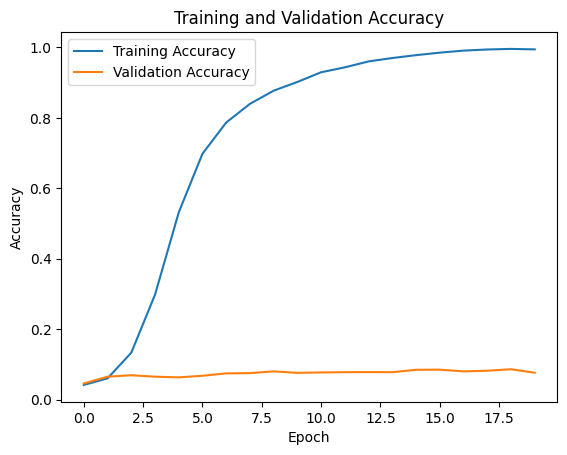

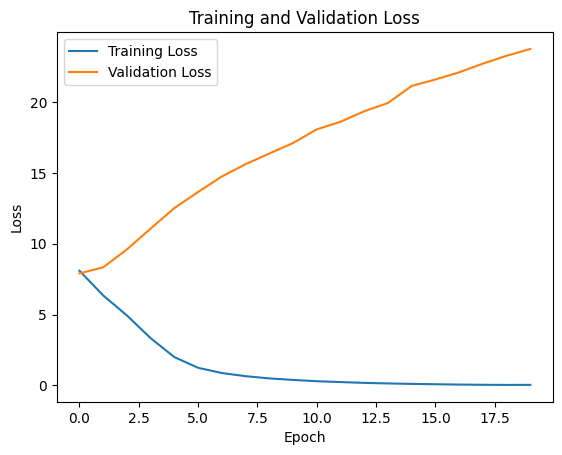

In [23]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()